In [1]:
%reload_ext autoreload
%autoreload 2
## sys package
import os, sys
import torch
from models.base_model import BaseModel
from models import networks
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd

In [2]:
class CycleGANModel(nn.Module):
    """
    This class implements the CycleGAN model, for learning image-to-image translation without paired data.

    The model training requires '--dataset_mode unaligned' dataset.
    By default, it uses a '--netG resnet_9blocks' ResNet generator,
    a '--netD basic' discriminator (PatchGAN introduced by pix2pix),
    and a least-square GANs objective ('--gan_mode lsgan').

    CycleGAN paper: https://arxiv.org/pdf/1703.10593.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.

        For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.
        A (source domain), B (target domain).
        Generators: G_A: A -> B; G_B: B -> A.
        Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
        Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
        Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
        Identity loss (optional): lambda_identity * (||G_A(B) - B|| * lambda_B + ||G_B(A) - A|| * lambda_A) (Sec 5.2 "Photo generation from paintings" in the paper)
        Dropout is not used in the original CycleGAN paper.
        """
        parser.set_defaults(no_dropout=True)  # default CycleGAN did not use dropout
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')

        return parser

    def __init__(self):
        """Initialize the CycleGAN class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        
        super(CycleGANModel, self).__init__()

        self.netG_A = networks.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                                        False, "normal", 0.02, [0])

    def forward(self, input):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        output = self.netG_A(input)  # G_A(A)
        return output

In [3]:
# opt = Option()
model = CycleGANModel()

initialize network with normal


In [4]:
weight = "./checkpoints/panda/200_net_G_A.pth"
model_dict = torch.load(weight)

In [5]:
model_dict_new = OrderedDict()
for key in model_dict:
    model_dict_new["netG_A.module."+key] = model_dict[key]

In [6]:
model.load_state_dict(model_dict_new)

<All keys matched successfully>

In [8]:
img_dir = "../tile_concat_wy/input/panda-36x256x256-tiles-data-opt/train"
save_dir = "../tile_concat_wy/input/panda-36x256x256-tiles-data-opt/train_norm"
imgs = os.listdir(img_dir)

In [8]:
model.eval()
for i, img_name in enumerate(tqdm(imgs[0:150000])):
    if not img_name.endswith(".png"):
        continue
    img = Image.open(os.path.join(img_dir, img_name)).convert('RGB')
#     img_id = imgs[idx].split('_')[0]
    img = np.asarray(img)
#     plt.imshow(img)
    img = img / 255.0
    img = (img - [0.5,0.5,0.5])/([0.5,0.5,0.5])
    img = img.transpose(2,0,1)
    img = np.expand_dims(img, 0)
    img_tensor = torch.tensor(img).float()
    img_norm = model(img_tensor)
    output = img_norm.detach().cpu().numpy().transpose(0,2,3,1)
    output = ((output + 1) / 2 * 255).astype(np.uint8)
    img_norm = Image.fromarray(output[0,:])
    img_norm.save(os.path.join(save_dir, img_name))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [31]:
img_name = imgs[12]
img = Image.open(os.path.join(img_dir, img_name)).convert('RGB')
csv_file = "../tile_concat_wy/input/csv_pkl_files/4_fold_whole_train.csv"
df = pd.read_csv(csv_file)
# df.head()
img_id = img_name.split("_")[0]
df = df.set_index("image_id")
provider = df.loc[img_id, "data_provider"]
print(provider)

radboud


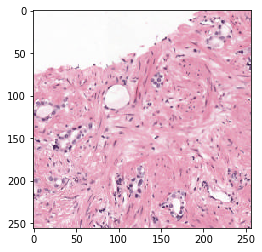

In [32]:
plt.imshow(img)

In [33]:
img = np.asarray(img)
img = img / 255.0
img = (img - [0.5,0.5,0.5])/([0.5,0.5,0.5])
img = img.transpose(2,0,1)
img = np.expand_dims(img, 0)
img_tensor = torch.tensor(img).float()
img_norm = model(img_tensor)
output = img_norm.detach().cpu().numpy().transpose(0,2,3,1)
output = ((output + 1) / 2 * 255).astype(np.uint8)

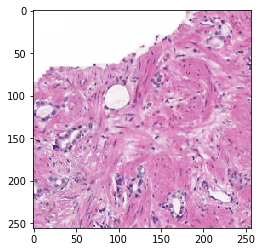

In [34]:
plt.imshow(output[0,])